In [1]:
%load_ext cython
import pyrost as rst
# import speckle_tracking as st
from pyrost.bin import *
from pyrost import simulation as st_sim
from pyrost import multislice as ms_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
from multiprocessing import cpu_count
from importlib import reload
from tqdm.auto import tqdm
from csaps import csaps

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, siunitx}'
# plt.rcParams['text.usetex'] = 'True'

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2b6dd8ccfd50>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'fft_convolve', 'gaussian_filter', 'gaussian_gradient_magnitude', 'np', 'pyfftw', 'st', 'st_update']


In [4]:
array = 1 * np.random.rand(1000, 1000) + 1j * np.ones((1000, 1000))
kernel = rst.bin.gaussian_kernel(50)

# out_fftw = dev.fft_convolve(array, kernel, backend='fftw', num_threads=2)
# out_np = dev.fft_convolve(array, kernel, backend='numpy', num_threads=2)
# out = rst.bin.fft_convolve(array.real, kernel) + 1j * rst.bin.fft_convolve(array.imag, kernel)

# out_fftw = dev.gaussian_filter(array, (10, 0), backend='fftw', num_threads=2)
# out_np = dev.gaussian_filter(array, (10, 0), backend='numpy', num_threads=2)
# out = rst.bin.gaussian_filter(array.real, (10, 0)) + 1j * rst.bin.gaussian_filter(array.imag, (10, 0))

out_fftw = dev.gaussian_gradient_magnitude(array, (10, 0), backend='fftw', num_threads=2)
out_np = dev.gaussian_gradient_magnitude(array, (10, 0), backend='numpy', num_threads=2)
out = np.sqrt(rst.bin.gaussian_gradient_magnitude(array.real, (10, 0))**2 + \
              rst.bin.gaussian_gradient_magnitude(array.imag, (10, 0))**2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
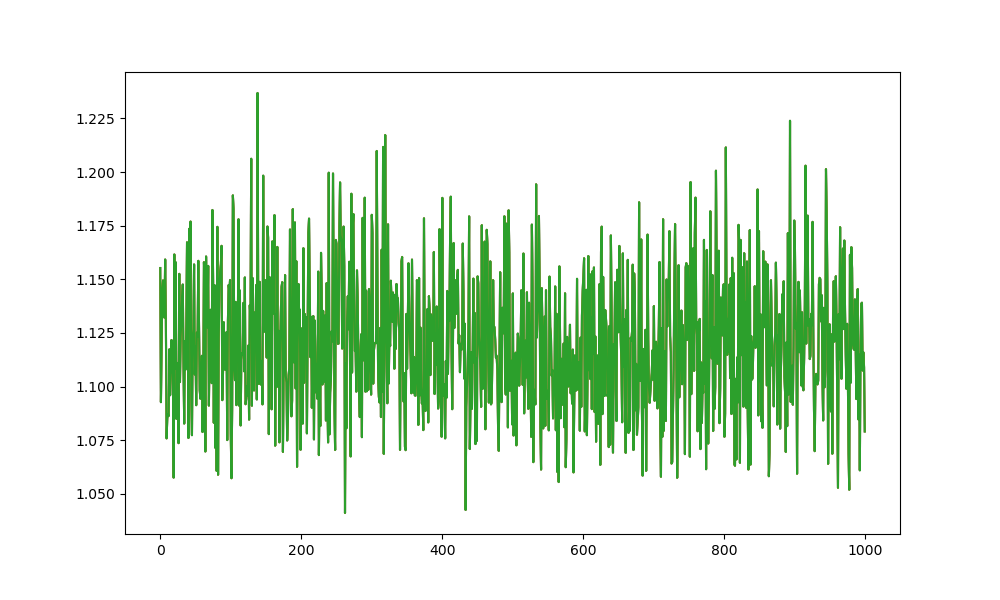

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(out_fftw[0])
ax.plot(out_np[0])
ax.plot(out[0])
plt.show()

In [12]:
sx_arr = np.random.rand(1000, 1000)
sy_arr = np.random.rand(1000, 1000)

%time res = dev.ct_integrate(sx_arr, sy_arr, 64)
%time res2 = rst.bin.ct_integrate(sx_arr, sy_arr)

AttributeError: module 'dev' has no attribute 'ct_integrate'

CPU times: user 5.59 s, sys: 28.4 ms, total: 5.62 s
Wall time: 5.62 s


In [2]:
params = st_sim.STParams.import_default(bar_size=0.3, bar_sigma=0.05, bar_atn=0.38,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                                        n_frames=100, defocus=40, alpha=0.04, ab_cnt=0.7,
                                        step_size=0.1, step_rnd=0.8, seed=8457259)
st_conv = st_sim.STConverter()
%time sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

CPU times: user 16.6 s, sys: 947 ms, total: 17.5 s
Wall time: 349 ms


In [2]:
data_dict = {}

for scan_num in [3649, 3653, 3655]:
    data_dict[scan_num] = rst.cxi_converter_sigray(scan_num, dir_path='/gpfs/cfel/group/cxi/labs/MLL-Sigray',
                                                   target='Mo', distance=None, lens='up', defocus_x=105e-6)
    data_dict[scan_num] = data_dict[scan_num].crop_data([200, 300, 380, 1480])
    data_dict[scan_num] = data_dict[scan_num].update_mask('perc-bad', pmax=99.999)
    data_dict[scan_num] = data_dict[scan_num].integrate_data(axis=0).mask_frames()

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

In [3]:
scan_num = 3649 # 3649, 3653, 3655


data = data_dict[scan_num]

In [6]:
data.whitefield.dtype

dtype('float32')

NameError: name 'r_vals' is not defined

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
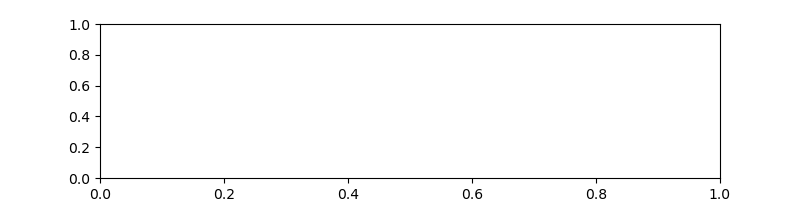

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 2))
# ax.imshow(data.get('data')[:, 0], vmax=15)
ax.plot(data.defocus_x * np.linspace(0.5, 2.0), r_vals)
fig.tight_layout()
plt.show()

In [7]:
st_obj = data.get_st(ds_x=5.0)

In [8]:
st_ref = data.get_st(ds_x=10.0).update_reference(hval=10.0)

st_pm = st_ref.update_pixel_map(sw_x=10, blur=12.0, method='de', loss='Huber',
                                extra_args={'grid_size': 100, 'pop_size': 10,
                                            'n_iter': 5})

In [9]:
st_ref.update_errors(loss='L1').error - st_pm.update_errors(loss='L1').error

0.0003908175311658768

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
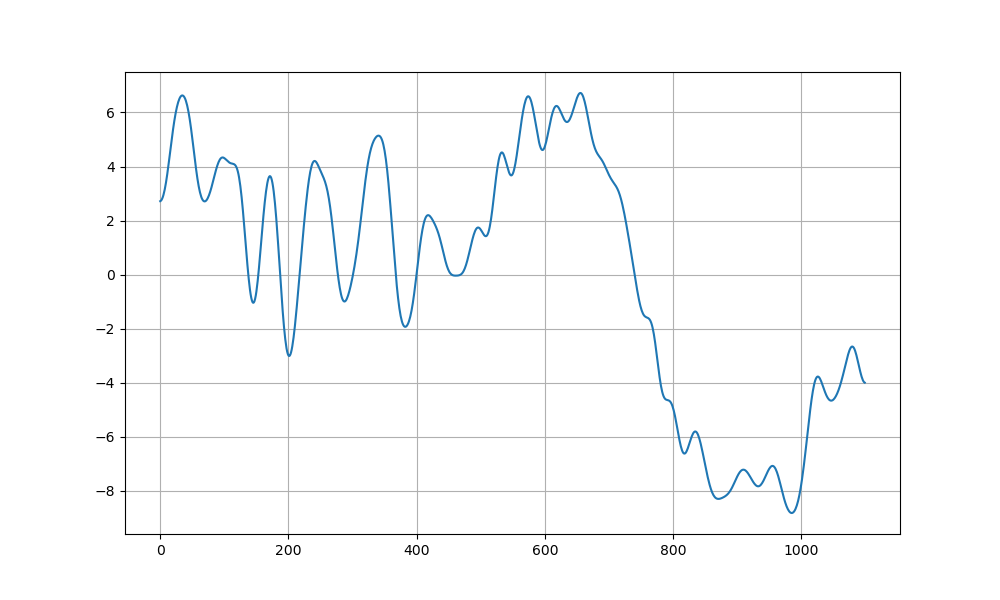

In [10]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(norm[0])
ax.plot((st_pm.pixel_map - st_ref.pixel_map)[1, 0])
ax.grid(True)
plt.show()

In [11]:
hopt = st_obj.find_hopt(h0=1.0, method='KerReg', loss='Epsilon', alpha=0.5)
print(hopt)

195.8647965704672


In [12]:
h_vals = np.geomspace(0.5, 40.0, 15)
errors = st_obj.ref_error_curve(h_vals, alpha=0.5, loss='Epsilon', method='KerReg')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
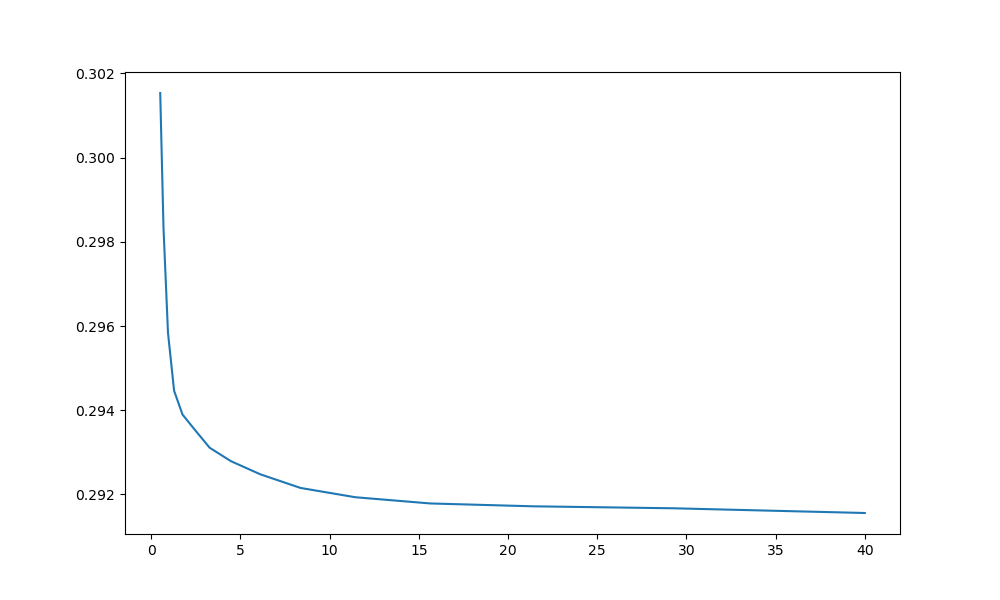

In [13]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(h_vals, errors)
plt.show()

In [14]:
st_res = st_obj.iter_update(sw_x=3, h0=3., n_iter=50, ref_method='KerReg',
                            pm_method='de', pm_args={'dims': (1, 50)},
                            verbose=True, options={'alpha': 4.0},
                            f_tol=-1e-1)

   0%            Iteration 0 / 50 [00:00<?, ?it/s]

Initial MSE = 0.313016, Initial h0 = 3.00


In [74]:
st_rgd = st_obj.iter_update_gd(sw_x=3, h0=3., n_iter=50, ref_method='KerReg',
                               pm_method='de', pm_args={'dims': (1, 50)},
                               verbose=True, options={'alpha': 0.5, 'loss': 'Epsilon', 'step': 512},
                               f_tol=-1e-1)

   0%            Iteration 0 / 50 [00:00<?, ?it/s]

Initial MSE = 0.316460, Initial h0 = 3.00


In [70]:
st_res = st_obj.iter_update(sw_x=3, h0=3., n_iter=50, ref_method='KerReg',
                            pm_method='gs', pm_args={'blur': 8.0},
                            verbose=True, options={'alpha': 4.0},
                            f_tol=-1e-1)

   0%            Iteration 0 / 50 [00:00<?, ?it/s]

Initial MSE = 0.316460, Initial h0 = 3.00


In [71]:
st_rgd, extra = st_obj.iter_update_gd(sw_x=3, h0=2., n_iter=50, ref_method='KerReg',
                               pm_method='gs', pm_args={'blur': 8.0},
                               verbose=True, options={'alpha': 0.5, 'loss': 'Epsilon', 'step': 2**13,
                                                      'return_extra': True},
                               f_tol=-1e-1)

   0%            Iteration 0 / 50 [00:00<?, ?it/s]

Initial MSE = 0.315965, Initial h0 = 2.00


In [43]:
st_ref = data_dict[3649].get_st(ds_x=5.0).iter_update_gd(sw_x=20, h0=20, n_iter=100, pm_method='gs',
                                                        pm_args={'dims': (1, 30), 'blur': 12.0},
                                                        options={'alpha': 2.0}, verbose=True)

   0%            Iteration 0 / 100 [00:00<?, ?it/s]

Initial MSE = 0.867309, Initial h0 = 20.00


In [11]:
st_ref = data_dict[3649].get_st(ds_x=5.0).iter_update_gd(sw_x=20, h0=20, n_iter=100, pm_method='gs',
                                                        pm_args={'dims': (1, 30), 'blur': 12.0},
                                                        options={'alpha': 2.0}, verbose=True)

   0%            Iteration 0 / 100 [00:00<?, ?it/s]

Initial MSE = 0.318420, Initial h0 = 20.00


In [75]:
%matplotlib widget
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

axes.plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), linestyle='dashed',
        label='Differential evolution, LOWESS')
axes.plot((st_rgd.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_rgd.pixel_map - st_obj.pixel_map)[1, 0].mean(), linestyle='dashed',
        label='Differential evolution, KerReg')

axes.legend(fontsize=15)
axes.grid(True)
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Multislice

In [ ]:
st_obj = data.get_st()
%time I0, n0, m0 = dev.make_reference(I_n=st_obj.data, W=st_obj.whitefield, u=st_obj.pixel_map, \
                      di=st_obj.di_pix, dj=st_obj.dj_pix, sw_y=0, \
                      sw_x=0, h=8., num_threads=st_obj.num_threads)
%time u = dev.update_pixel_map(I_n=st_obj.data, W=st_obj.whitefield, I0=I0, \
                u0=st_obj.pixel_map, di=st_obj.di_pix - n0, dj=st_obj.dj_pix - m0, \
                sw_y=0, sw_x=100, h=0.0, num_threads=st_obj.num_threads)
%time dij = dev.update_translations(I_n=st_obj.data, W=st_obj.whitefield, I0=I0, \
                u=u, di=st_obj.di_pix - n0, dj=st_obj.dj_pix - m0, \
                sw_y=0, sw_x=100, h=0.0, num_threads=st_obj.num_threads)

In [ ]:
st_obj = data.get_st()
%time _ = rst.bin.make_reference(I_n=st_obj.data, W=st_obj.whitefield, u=st_obj.pixel_map, \
                      di=st_obj.di_pix, dj=st_obj.dj_pix, sw_y=0, \
                      sw_x=0, ls=8., num_threads=st_obj.num_threads)
%time _ = rst.bin.update_pixel_map(I_n=st_obj.data, W=st_obj.whitefield, I0=I0, \
                u0=st_obj.pixel_map, di=st_obj.di_pix - n0, dj=st_obj.dj_pix - m0, \
                sw_y=0, sw_x=100, ls=0.0, num_threads=st_obj.num_threads)
%time _ = rst.bin.update_translations(I_n=st_obj.data, W=st_obj.whitefield, I0=I0, \
                u=u, di=st_obj.di_pix - n0, dj=st_obj.dj_pix - m0, \
                sw_y=0, sw_x=100, ls=0.0, num_threads=st_obj.num_threads)

In [3]:
# Recipe simulation

en = 17.48e3
wl = ms_sim.MLL.en_to_wl / en
n_min = 700
mll_mat1 = ms_sim.Material(formula='SiC', density=2.67)
mll_mat2 = ms_sim.Material(formula='WC', density=13.87)
params = ms_sim.MSParams.import_default(x_step=1e-4, z_step=9e-3, n_min=n_min, n_max=n_min + 21710,
                                        focus=1.25e3, mll_sigma=2e-4, mll_wl=wl, wl=wl, x_min=5., x_max=45.,
                                        mll_depth=9.33, mll_mat1=mll_mat1, mll_mat2=mll_mat2)
mll = ms_sim.MLL.import_params(params)

d_n = np.loadtxt('results/mll_recipe/MLL_profiles-02.txt') * 8e-4
params.focus = 8e2
d_lyr = np.repeat(d_n / 2, 2)
z_coords = params.z_step * np.arange(params.mll_depth // params.z_step)
mll.layers = (np.cumsum(d_lyr) + 8.) - z_coords[:, None] * np.repeat(params.mll_wl / 2 / d_n, 2)
print(d_n.shape, mll.layers.shape, mll.layers.min(), mll.layers.max())
print(mll.layers.shape)

(10854,) (1036, 21708) 7.958910772998954 36.063417825360034
(1036, 21708)


In [4]:
# Ideal MLL simulation

en = 60.0e3
wl = ms_sim.MLL.en_to_wl / en
n_min, n_layers = 700, 20000
mll_mat1 = ms_sim.Material(formula='SiC', density=2.67)
mll_mat2 = ms_sim.Material(formula='WC', density=13.87)
params = ms_sim.MSParams.import_default(x_step=1e-4, z_step=1e-2, n_min=n_min, n_max=n_min + n_layers,
                                        focus=2.5e3, mll_sigma=2e-4, mll_wl=wl, wl=wl, x_min=5., x_max=40.,
                                        mll_depth=60.0, mll_mat1=mll_mat1, mll_mat2=mll_mat2)
mll = ms_sim.MLL.import_params(params)

ksize = 1e3
ms_prgt = ms_sim.MSPropagator(params, mll)
wf_inc = gaussian_filter(ms_prgt.wf_inc.real, ksize) + 1j * gaussian_filter(ms_prgt.wf_inc.imag, ksize)
ms_prgt = ms_prgt.update_inc_wavefront(wf_inc)

ms_prgt.beam_propagate(verbose=True)
print(mll.layers.shape, mll.layers.min(), mll.layers.max())

   0%            Slice 0 / 5999 [00:00<?, ?it/s]

(5999, 20000) 5.941356003118587 32.701035785822185


In [ ]:
ml_ds = (5. + np.cumsum(0.5 * mll_d * np.linspace(0.983, 0.9998, 2 * (params.n_max - params.n_min))))
ml_zs = params.z_step * np.arange(params.mll_depth // params.z_step)
layers = ml_ds - ml_zs[:, None] * np.tan(np.linspace(0, np.pi / 1.8e4, ml_ds.size))

In [ ]:
st_sim.MLL.en_to_wl / 60.00e3

In [ ]:
# Multilayer simulation

en = 60.0e3
mll_d = 10e-3
mll_z = 55.
mll_ap = 30.
wedge = 0.0
strain = 0.0

wl = st_sim.MLL.en_to_wl / en
mll_mat1 = st_sim.Material(formula='SiC', density=2.67)
mll_mat2 = st_sim.Material(formula='WC', density=13.87)
bragg = np.arcsin(0.5 * wl / mll_d)
x_mgn = 5.
params = st_sim.MSParams.import_default(x_step=1e-4, z_step=2e-2, n_min=x_mgn / mll_d,
                                        n_max=(x_mgn + mll_ap) / mll_d, mll_sigma=0.2e-4, wl=wl,
                                        x_min=0., x_max=40., mll_depth=mll_z,
                                        mll_mat1=mll_mat1, mll_mat2=mll_mat2,
                                        focus=30 / np.tan(bragg))

ml_ds = (x_mgn + np.cumsum(0.5 * mll_d * np.linspace(1.0 - strain, 1.0, 2 * (params.n_max - params.n_min))))
ml_zs = params.z_step * np.arange(params.mll_depth // params.z_step)
layers = ml_ds - ml_zs[:, None] * np.tan(np.linspace(0, wedge, ml_ds.size))
mll = st_sim.MLL(mat1_r=params.get_mat1_r(en), mat2_r=params.get_mat2_r(en),
                 sigma=params.mll_sigma, layers=layers)

ms_prgt = st_sim.MSPropagator(params, mll)

ksize = 0.33 * (ms_prgt.x_arr[1] - ms_prgt.x_arr[0])**-1 # 3 sigma = 1 um
x_lb, x_ub = x_mgn + 1., x_mgn + mll_ap - 1.
wf_inc = np.ones(ms_prgt.x_arr.shape, dtype=np.complex128)
wf_inc[(ms_prgt.x_arr < x_lb) | (ms_prgt.x_arr > x_ub)] = 0.
wf_inc = rst.bin.gaussian_filter(wf_inc.real, ksize) + \
         1j * rst.bin.gaussian_filter(wf_inc.imag, ksize)

In [ ]:
th_max = 0.15e-3
n_thetas = 250

bin_ratio = ms_prgt.size // 1000
z_arr = ms_prgt.z_arr[::int((ms_prgt.z_arr[1] - ms_prgt.z_arr[0])**-1)] # every 1 um
thetas = np.sin(bragg) + np.linspace(-th_max, th_max, n_thetas)
mll_beam = np.array([params.x_min, params.x_max])
diff_beam = mll_beam + np.tan(thetas - 2 * bragg)[:, None] * params.focus
drct_beam = mll_beam + np.tan(thetas)[:, None] * params.focus
ratio = np.ceil(2 * (np.tan(2 * bragg) + th_max) * params.focus / (params.x_max - params.x_min) + 1)
xs_foc = ratio * params.x_step * (np.arange(ms_prgt.size) - ms_prgt.size // 2) + np.mean(ms_prgt.x_arr)
xs_foc = xs_foc.reshape((bin_ratio, -1)).mean(axis=1)

In [ ]:
verbose = True
size = int((ratio * (1 + ratio) * params.x_step**2 / params.wl / params.focus)**-1)

wfts = []
for theta in tqdm(thetas, disable=not verbose,
                  bar_format='{desc} {percentage:3.0f}% {bar} Angle {n_fmt} / {total_fmt} '\
                             '[{elapsed}<{remaining}, {rate_fmt}{postfix}]'):
    ms_prgt.update_inc_wavefront.inplace_update(wf_inc * np.exp(2j * np.pi / params.wl * theta * ms_prgt.x_arr))
    ms_prgt.beam_propagate(verbose=False)
    wfts_theta = []
    for z, wft in zip(z_arr, ms_prgt.beam_profile[::int((ms_prgt.z_arr[1] - ms_prgt.z_arr[0])**-1)]):
        wft_foc = rst.bin.rsc_wp(wft, params.x_step, ratio * params.x_step,
                                 params.focus - z, params.wl)
        if size < wft.size:
            wft_foc[:(wft.size - size) // 2] = 0.0
            wft_foc[(size - wft.size) // 2:] = 0.0
        wfts_theta.append((np.abs(wft_foc)**2).reshape((bin_ratio, -1)).mean(axis=1))
    wfts.append(np.stack(wfts_theta, axis=0))
wfts = np.stack(wfts, axis=1)

In [ ]:
diff_mask = np.tile((xs_foc > diff_beam[:, 0, None]) & (xs_foc < diff_beam[:, 1, None])[None, ...],
                    (z_arr.size, 1, 1))
drct_mask = np.tile((xs_foc > drct_beam[:, 0, None]) & (xs_foc < drct_beam[:, 1, None])[None, ...],
                    (z_arr.size, 1, 1))
diff_sum = np.sum(wfts * diff_mask, axis=-1)
drct_sum = np.sum(wfts * drct_mask, axis=-1)
effs = diff_sum / (diff_sum + drct_sum)

In [ ]:
with h5py.File('results/mslice_60_keV.h5', 'r') as h5_file:
    effs = h5_file['entry/efficiencies'][()]

with h5py.File('results/mslice_10mdeg_wedge_60_keV.h5', 'r') as h5_file:
    xs_foc = h5_file['entry/xcoordinates'][()]
    wfts = h5_file['entry/wavefronts'][()]
    thetas = h5_file['entry/thetas'][()]
    z_arr = h5_file['entry/thicknesses'][()]
    effs_10_wedge = h5_file['entry/efficiencies'][()]

with h5py.File('results/mslice_20mdeg_wedge_60_keV.h5', 'r') as h5_file:
    effs_20_wedge = h5_file['entry/efficiencies'][()]

In [ ]:
with h5py.File('results/mslice_100_mllz_60_keV.h5', 'r') as h5_file:
    xs_foc = h5_file['entry/xcoordinates'][()]
    wfts = h5_file['entry/wavefronts'][()]
    thetas = h5_file['entry/thetas'][()]
    z_arr = h5_file['entry/thicknesses'][()]
    effs = h5_file['entry/efficiencies'][()]

with h5py.File('results/mslice_100_mllz_10mdeg_wedge_60_keV.h5', 'r') as h5_file:
    effs_10_wedge = h5_file['entry/efficiencies'][()]

with h5py.File('results/mslice_100_mllz_20mdeg_wedge_60_keV.h5', 'r') as h5_file:
    effs_20_wedge = h5_file['entry/efficiencies'][()]

In [ ]:
with h5py.File('results/mslice_1nm_17_keV_250_pts.h5', 'r') as h5_file:
    xs_foc = h5_file['entry/xcoordinates'][()]
    wfts = h5_file['entry/wavefronts'][()]
    thetas = h5_file['entry/thetas'][()]
    z_arr = h5_file['entry/thicknesses'][()]
    effs_1nm = h5_file['entry/efficiencies'][()]

In [ ]:
%matplotlib inline
idx = (50, 125)

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.plot(xs_foc, wfts[idx])
# axes.plot(xs_foc[[diff_mask[idx]]], wfts[idx][diff_mask[idx]])
# axes.plot(xs_foc[[drct_mask[idx]]], wfts[idx][drct_mask[idx]])
axes.set_title('Focal plane', fontsize=20)
axes.set_xlabel('x coordinate, um', fontsize=15)
axes.set_ylabel('Focal beam energy, a.u.', fontsize=15)
axes.tick_params(labelsize=15)
axes.grid(True)
plt.show()

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/gpfs/cfel/user/nivanov/.conda/envs/pyrost/bin/ffmpeg'

ims = []
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.set_xlabel('x coordinate, um', fontsize=15)
axes.set_ylabel('Beam absolute', fontsize=15)
axes.set_xlim(xs_foc.min(), xs_foc.max())
axes.set_ylim(0.0, wfts[50].max())
axes.tick_params(labelsize=15)

axes.grid(True)

z = 60

im_0, = axes.plot(xs_foc, wfts[z, 0], c='r',
                  label=f'Grating thickness = {z:d} um')
axes.set_title(f'Bragg offset = {np.rad2deg(thetas[0] - bragg) * 1e3:.2f} mdeg', fontsize=20)
axes.legend(fontsize=15)

def update(iternum): 
    im_0.set_data(xs_foc, wfts[z, iternum])
    axes.set_title(f'Bragg offset = {np.rad2deg(thetas[iternum] - bragg) * 1e3:.2f} mdeg', fontsize=20)
    return im_0,
    

ani = animation.FuncAnimation(fig, update, frames=thetas.size, interval=100, blit=True)
    
FFwriter = animation.FFMpegWriter(extra_args=['-vcodec', 'libx264'])
# ani.save('figures/mslice_wedged_grating_60_kev.mp4', writer=FFwriter)
plt.show()

In [ ]:
%matplotlib inline
idx = 70

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(np.rad2deg(thetas - bragg) * 1e3, effs[idx], label='no wedge')
axes.plot(np.rad2deg(thetas - bragg) * 1e3, effs_10_wedge[idx], label='10 mdeg wedge')
axes.plot(np.rad2deg(thetas - bragg) * 1e3, effs_20_wedge[idx], label='20 mdeg wedge')
axes.set_title('Focal plane', fontsize=20)
axes.set_xlabel('Angle of incidence, mdeg', fontsize=15)
axes.set_ylabel('Focal beam energy, a.u.', fontsize=15)
axes.legend(fontsize=20)
axes.tick_params(labelsize=15)
axes.grid(True)
plt.show()

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/gpfs/cfel/user/nivanov/.conda/envs/pyrost/bin/ffmpeg'

ims = []
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.set_xlabel('Angle of incidence, mdeg', fontsize=15)
axes.set_ylabel('Grating efficiency, [0.0 - 1.0]', fontsize=15)
axes.set_xlim(np.rad2deg(thetas - bragg).min() * 1e3, np.rad2deg(thetas - bragg).max() * 1e3)
axes.set_ylim(0.0, 1.0)
axes.tick_params(labelsize=15)

axes.grid(True)

im_0, = axes.plot(np.rad2deg(thetas - bragg) * 1e3, effs[0], c='r', label='10 nm period')
im_1, = axes.plot(np.rad2deg(thetas - bragg) * 1e3, effs_10_wedge[0], c='b', label='10 nm period, 10 mdeg wedge')
im_2, = axes.plot(np.rad2deg(thetas - bragg) * 1e3, effs_20_wedge[0], c='g', label='10 nm period, 20 mdeg wedge')
axes.set_title(f'Grating thickness = {z_arr[0]:.1f} um', fontsize=20)
axes.legend(fontsize=15)

def update(iternum): 
    im_0.set_data(np.rad2deg(thetas - bragg) * 1e3, effs[iternum])
    im_1.set_data(np.rad2deg(thetas - bragg) * 1e3, effs_10_wedge[iternum])
    im_2.set_data(np.rad2deg(thetas - bragg) * 1e3, effs_20_wedge[iternum])
    axes.set_title(f'Grating thickness = {z_arr[iternum]:.1f} um', fontsize=20)
    return im_0, im_1, im_2
    

ani = animation.FuncAnimation(fig, update, frames=z_arr.size, interval=200, blit=True)
    
FFwriter = animation.FFMpegWriter(extra_args=['-vcodec', 'libx264'])
# ani.save('figures/mslice_10nm_mlld.mp4', writer=FFwriter, dpi=200)
plt.show()

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(ms_prgt.x_arr[::100], np.abs(ms_prgt.beam_profile[0, ::100])**2)
axes[0].set_title('Entry surface', fontsize=20)
axes[0].plot(ms_prgt.x_arr[::100], np.abs(ms_prgt.wf_inc[::100])**2)
axes[1].plot(ms_prgt.x_arr[::100], np.abs(ms_prgt.beam_profile[-1, ::100])**2)
axes[1].set_title('Exit surface', fontsize=20)
plt.show()

In [ ]:
w_pad = 100
wft = np.pad(ms_prgt.beam_profile[-1], (w_pad, w_pad))

focus_step = 4 * params.x_step
wft_focus = rsc_wp(wft, params.x_step, focus_step, params.focus - params.mll_depth, params.wl)[w_pad:-w_pad]
xfocus = focus_step * np.arange(-wft_focus.size // 2, wft_focus.size - wft_focus.size // 2)
xfocus += np.mean(ms_prgt.x_arr)

# det_dist = 2e5
# M = det_dist / params.focus * 4.
# far_step = M * params.x_step
# wft_far = fraunhofer_wp(wft, params.x_step, far_step, det_dist, params.wl)[w_pad:-w_pad]
# xfar = far_step * np.arange(-wft_far.size // 2, wft_far.size - wft_far.size // 2) + np.mean(ms_prgt.x_arr)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xfocus, np.abs(wft_focus)**2)
plt.show()

In [ ]:
foc_step = 4 * params.x_step

wfts_foc, xs_foc = {}, {}
for z, wft in zip(ms_prgt.z_arr[::50], ms_prgt.beam_profile[::50]):

    wft_foc = rsc_wp(wft, params.x_step, foc_step, params.focus - z, params.wl)
    x_foc = foc_step * np.arange(-wft_foc.size // 2, wft_foc.size - wft_foc.size // 2) + \
            np.mean(ms_prgt.x_arr)
    
    wfts_foc[z] = wft_foc
    xs_foc[z] = x_foc

In [ ]:
foc_step = 4 * params.x_step

wfts_foc = {z: {} for z in ms_prgt.z_arr[::50]}
xs_foc = foc_step * np.arange(-ms_prgt.size // 2, ms_prgt.size - ms_prgt.size // 2) + \
         np.mean(ms_prgt.x_arr)
for bragg, ms_prgt in ms_dict.items():
    for z, wft in zip(ms_prgt.z_arr[::50], ms_prgt.beam_profile[::50]):

        wft_foc = rsc_wp(wft, params.x_step, foc_step, params.focus - z, params.wl)
        wfts_foc[z][bragg] = wft_foc

In [ ]:
sums = np.array([np.sum(np.abs(wft_foc[:wft_foc.size // 2])**2) / np.sum(np.abs(wft_foc)**2)
                 for wft_foc in wfts_foc.values()])

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
for z in [10, 32, 59]:
    axes.plot(xs_foc[z], np.abs(wfts_foc[z])**2, label=f'MLL thickness = {z} um')
axes.legend(fontsize=15)
axes.set_xlim(44.99, 45.01)
axes.set_title('Focal plane', fontsize=20)
axes.set_xlabel('x coordinate, um', fontsize=15)
axes.set_ylabel('Intensity, a.u.', fontsize=15)
axes.tick_params(labelsize=15)
axes.grid(True)
plt.show()

In [ ]:
from pyrost.aberrations_fit import LeastSquares

x_min, x_max = 16.5, 35.
x_beam = xfocus[(xfocus > x_min) & (xfocus < x_max)]
theta = (x_beam - x_min) / params.focus

mag = np.abs(wft_focus[(xfocus > x_min) & (xfocus < x_max)])**2
phase = np.unwrap(np.angle(wft_focus[(xfocus > x_min) & (xfocus < x_max)]))

quad_fit = LeastSquares.fit(theta, phase, max_order=2)[0]
aber = phase - LeastSquares.model(quad_fit, theta, (0, x_beam.size))

ab_fit = LeastSquares.fit(theta, aber, max_order=4)[0]

In [ ]:
from pyrost.aberrations_fit import LeastSquares

# x_min, x_max = 161, 196.
x_min, x_max = 143, 171
x_beam = x_arr[(x_arr > x_min) & (x_arr < x_max)]
theta = (x_beam - x_arr.mean()) / params.focus
# theta = (x_arr[(x_arr > x_min) & (x_arr < x_max)]) / params.focus
mag = np.abs(ds_beam[:, 99][(x_arr > x_min) & (x_arr < x_max)])**2
phase = np.unwrap(np.angle(ds_beam[:, 99][(x_arr > x_min) & (x_arr < x_max)]))

quad_fit = LeastSquares.fit(theta, phase, max_order=2)[0]
aber = phase - LeastSquares.model(quad_fit, theta, (0, x_beam.size))

ab_fit = LeastSquares.fit(theta, aber, max_order=4)[0]

In [ ]:
defocus = quad_fit[-3] * params.wl / np.pi
ab_fit[-4] * 1e-9, ab_fit[-5] * 1e-12

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(theta, mag, label='Multislice')
axes[0].set_title('Magnitude, a.u.', fontsize=20)
axes[1].plot(theta, phase, label='Multislice')
axes[1].plot(theta, LeastSquares.model(quad_fit, theta, (0, x_beam.size)),
             label=f'Defocus = {params.focus:.0f} um')
axes[1].set_title('Phase, rad.', fontsize=20)
axes[2].plot(theta, aber, label='Multislice')
axes[2].plot(theta, LeastSquares.model(ab_fit, theta, (0, x_beam.size)),
             label=f'$c_3$ = {ab_fit[-4] * 1e-9:.3e} rad / mrad^3\n$c_4$ = {ab_fit[-5] * 1e-12:.3e} rad / mrad^4')
axes[2].set_title('Phase aberrations, rad.', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, um', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
z_arr = np.linspace(0.1 * params.focus, 4. * params.focus, 50)
ds_beam, x_arr = ms_prgt.beam_downstream(z_arr, 1.5 * params.x_step)

In [ ]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im1 = ax.imshow(np.abs(ds_beam[::100]), vmin=0.1, vmax=2., cmap='gist_heat_r',
                extent=[z_arr.min(), z_arr.max(), x_arr.max(), x_arr.min()])
cbar = fig.colorbar(im1, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('Normalized intensity, a.u.', fontsize=20)
ax.set_title('Beam profile', fontsize=25)
ax.set_ylabel(r'x coordinate, $\mu m$', fontsize=20)
ax.set_aspect(20)
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$z_1, \mu m$', fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.show()

# Beamtime preparation

In [ ]:
data_obj = data_obj.crop_data((0, data.shape[1], 0, 1400))
data_obj = data_obj.update_mask(pmax=99.999)

size = 5
kernel = np.ones(int(size)) / size
mean = data_obj.whitefield.copy()
mean = fft_convolve(mean, kernel, mode='reflect', axis=0)
mean = fft_convolve(mean, kernel, mode='reflect', axis=1)
mean_sq = data_obj.whitefield**2
mean_sq = fft_convolve(mean_sq, kernel, mode='reflect', axis=0)
mean_sq = fft_convolve(mean_sq, kernel, mode='reflect', axis=1)

In [ ]:
r_image = mean_sq - mean**2
r_min = np.max(r_image[:, :50])
r_max = np.max(r_image)
r_image = np.clip(r_image, r_min, r_max) - r_min

In [ ]:
from scipy.ndimage import label, generate_binary_structure, sum_labels

s = generate_binary_structure(size, size)
labels, num_labels = label(r_image)
fbeam_lbl, db_lbl = np.argsort(sum_labels(r_image, labels, np.arange(num_labels + 1)))[-2:]
ss_arr, fs_arr = np.where(labels == fbeam_lbl)
roi = np.array([ss_arr.min(), ss_arr.max(), fs_arr.min()])

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 6))
# axes.imshow(data_obj.whitefield, vmax=100)
axes.imshow(labels == fbeam_lbl, vmax=1)
plt.show()

# ST Simulation

In [6]:
params = st_sim.STParams.import_default(bar_size=5.5, bar_sigma=5., bar_atn=0.1,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=1e5, th_s=1.5e-4,
                                        n_frames=100, defocus=120, alpha=0.01, ab_cnt=0.7,
                                        step_size=1, step_rnd=0.8, distance=2e6, seed=8457259)

globals().update(**params.export_dict())
print(params)

{'exp_geom': {'defocus': 120.0, 'det_dist': 2000000.0, 'n_frames': 100, '...': '...'}, 'detector': {'detx_size': 2000, 'dety_size': 1000, 'pix_size': 55.0}, 'source': {'p0': 100000.0, 'th_s': 0.00015, 'wl': 7.29e-05}, '...': '...'}


In [7]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, dx0 = params.lens_x_wavefront(return_step=True)
lens_wfy, dy0 = params.lens_y_wavefront(return_step=True)
print(n_x, n_y)

58527 1508


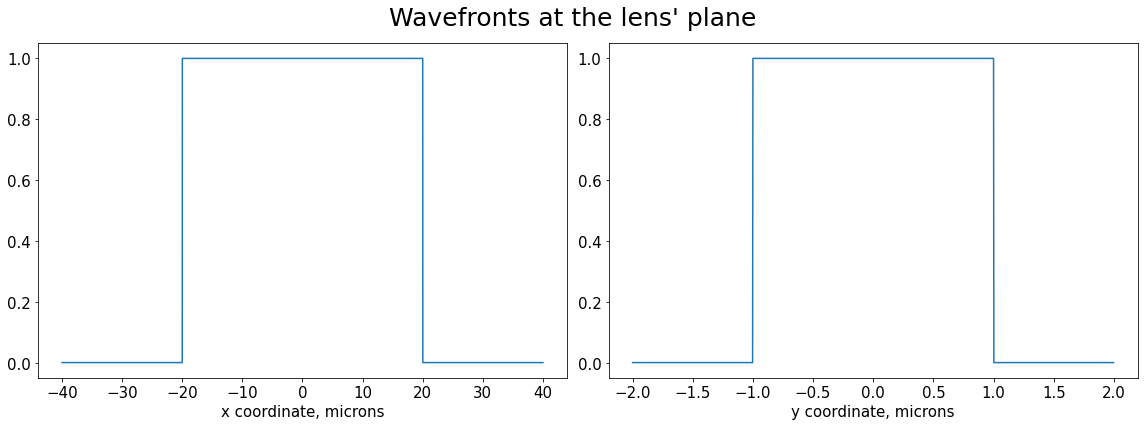

In [8]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [9]:
dx1, dy1 = dx0 * params.defocus / params.focus, dy0
z01 = params.focus + params.defocus
%time defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, params.wl, num_threads=1, backend='numpy')
%time defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, params.wl, num_threads=12, backend='numpy')

CPU times: user 28.1 ms, sys: 1.3 ms, total: 29.4 ms
Wall time: 28.4 ms
CPU times: user 821 µs, sys: 600 µs, total: 1.42 ms
Wall time: 1.25 ms


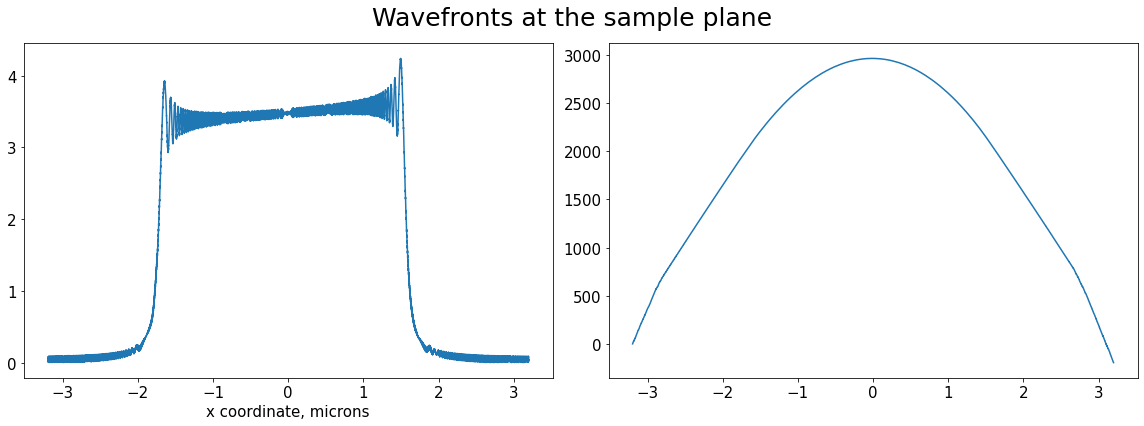

In [10]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dx1 * nx_arr, np.unwrap(np.angle(defoc_wfx)))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [11]:
x0, x1 = params.beam_span(params.defocus)
x1 += params.step_size * params.n_frames
bar_pos = bar_positions(x0 + params.offset, x1 - params.offset, params.bar_size, params.bar_rnd, params.seed)

In [12]:
nx_arr.shape, params.bar_sigma / dx1

((58527,), 45724.21875)

In [13]:
smp_pos = params.sample_positions()

overlap = int(params.bar_sigma / dx1)
# nx_ext = np.arange(-(n_x + overlap) // 2, (n_x + overlap) // 2)
x_arr = dx1 * nx_arr + smp_pos[:, None]

%time b_tr = barcode_profile(x_arr=x_arr, bars=bar_pos, bulk_atn=params.bulk_atn, \
                             bar_atn=params.bar_atn, bar_sigma=0.0, \
                             num_threads=64)
b_tr = gaussian_filter(b_tr, (0.0, params.bar_sigma / dx1), num_threads=64, mode='nearest')
# b_tr = gaussian_filter(b_tr, (0.0, params.bar_sigma / dx1), num_threads=64, mode='nearest')[:, overlap // 2:-overlap // 2]
# b_tr = b_tr[:, overlap // 2:-overlap // 2]
smp_wfx = defoc_wfx * b_tr

CPU times: user 2.02 s, sys: 166 ms, total: 2.18 s
Wall time: 55.5 ms


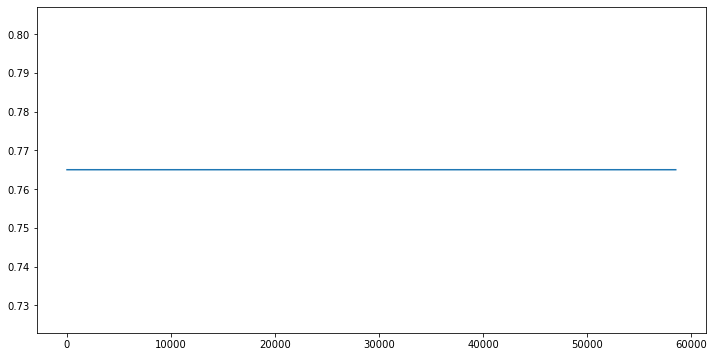

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.abs(b_tr[0]))
plt.show()

In [15]:
dx2, dy2 = params.detx_size * params.pix_size / n_x, params.dety_size * params.pix_size / n_y
%time det_wfx = fraunhofer_wp(smp_wfx, dx1, dx2, params.det_dist, params.wl, num_threads=12, backend='fftw')
%time det_wfy = fraunhofer_wp(defoc_wfy, dy1, dy2, params.det_dist, params.wl, num_threads=12, backend='fftw')
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 2.28 s, sys: 56.1 ms, total: 2.33 s
Wall time: 195 ms
CPU times: user 34.9 ms, sys: 4.52 ms, total: 39.4 ms
Wall time: 3.27 ms
(100, 58527) (100, 58527)


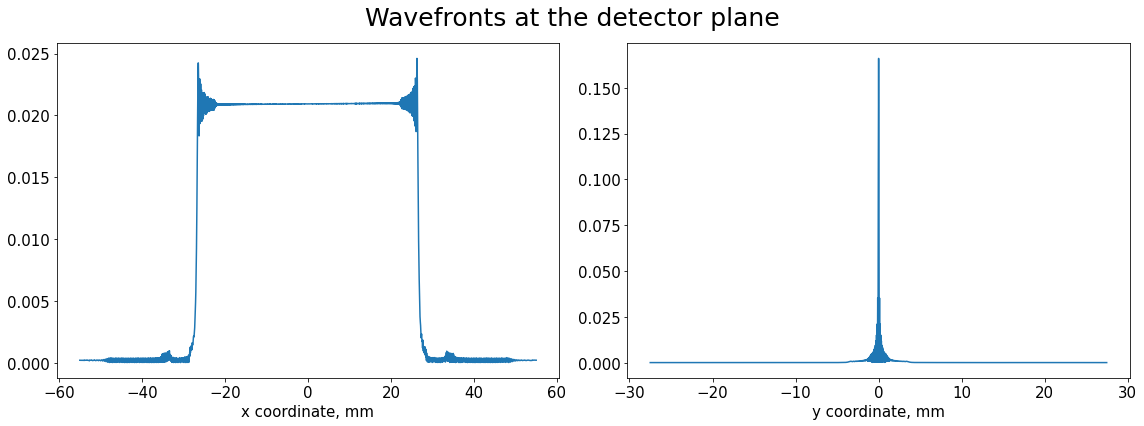

In [16]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[2]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [17]:
sc_x = params.source_curve(params.defocus + params.det_dist, dx2)
sc_y = params.source_curve(params.defocus + params.det_dist, dy2)
pfx = np.sqrt(params.p0) / params.ap_x * np.abs(det_wfx)**2
pfy = np.sqrt(params.p0) / params.ap_y * np.abs(det_wfy)**2
print(pfx.shape, sc_x.shape)
%time det_ix = fft_convolve(pfx, sc_x, num_threads=12, backend='fftw')
%time det_iy = fft_convolve(pfy, sc_y, num_threads=12, backend='fftw')
# print(det_ix.shape, det_iy.shape)

(100, 58527) (1277,)
CPU times: user 439 ms, sys: 51.5 ms, total: 490 ms
Wall time: 41 ms
CPU times: user 10.5 ms, sys: 366 µs, total: 10.9 ms
Wall time: 902 µs


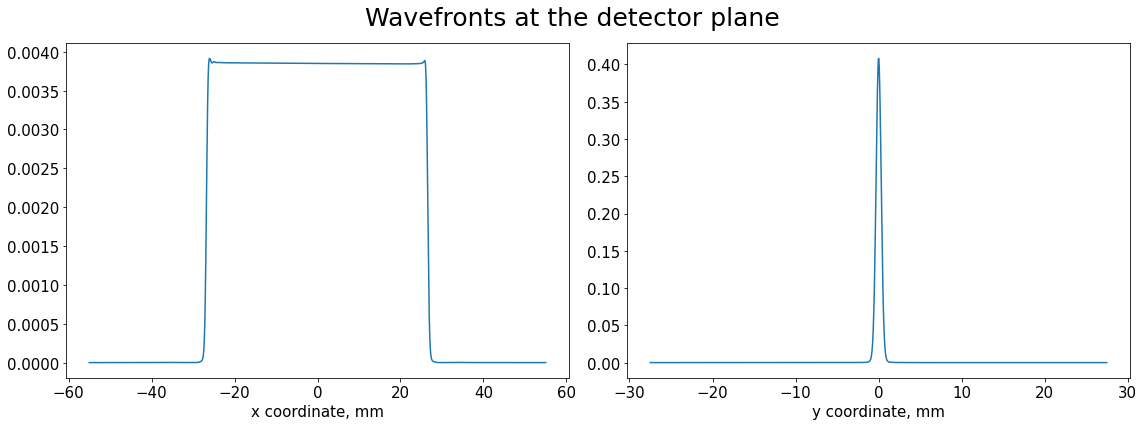

In [18]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, det_ix[62])
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, det_iy)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [21]:
wfx = np.ones(params.detx_size)
wfy = np.ones(params.dety_size)
%time frames = make_frames(pfx=det_ix, pfy=det_iy, dx=dx2, dy=dy2, \
                           shape=(params.dety_size, params.detx_size), \
                           seed=params.seed, num_threads=64)
%time wfield = median(frames, axis=0, num_threads=64)
# frames.shape, wfield.shape

CPU times: user 24 s, sys: 6.44 s, total: 30.4 s
Wall time: 478 ms
CPU times: user 11.6 s, sys: 554 ms, total: 12.2 s
Wall time: 190 ms


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
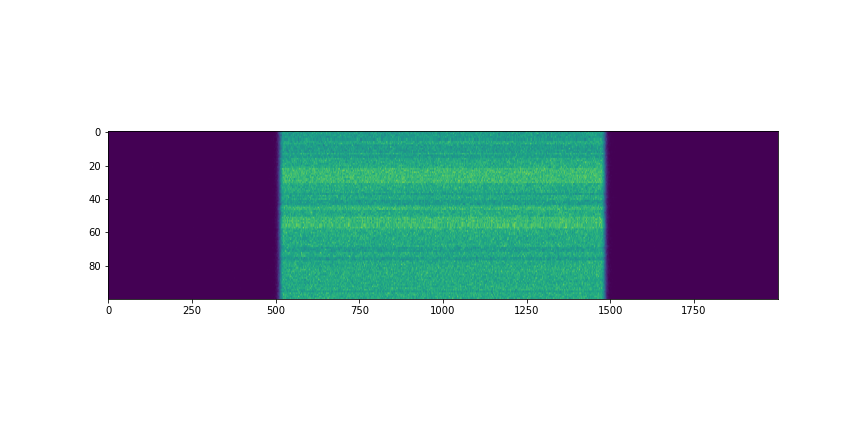

In [22]:
%matplotlib notebook
fig, axes = plt.subplots(figsize=(12, 6))
axes.imshow(frames.sum(axis=1))
axes.set_aspect(5)
plt.show()

In [ ]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [ ]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'ct_integrate', 'fourier_basis', 'np', 'pm_devolution', 'pm_gsearch', 'pm_rsearch', 'pyfftw', 'st', 'st_update']


In [5]:
params = st_sim.STParams.import_default(bar_size=0.5, bar_sigma=0.4, bar_atn=0.319,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=1.5e4, th_s=2.5e-4,
                                        n_frames=100, defocus=120, alpha=0.1, ab_cnt=0.5,
                                        step_size=0.2, step_rnd=0.8, distance=2e6, seed=8457259,
                                        det_dist=4.9e6, ap_x=20)
st_conv = st_sim.STConverter()
%time sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

CPU times: user 4.7 s, sys: 378 ms, total: 5.08 s
Wall time: 92.6 ms


In [24]:
mll_mat1 = ms_sim.Material(formula='SiC', density=2.67)
mll_mat2 = ms_sim.Material(formula='WC', density=13.87)
print(1 - np.exp(-2 * np.pi / params.wl *
                 mll_mat2.get_ref_index(ms_sim.Material.en_to_wl / params.wl * 1e-4).imag * 6.16))
print(1 - np.exp(-2 * np.pi / params.wl *
                 mll_mat2.get_ref_index(ms_sim.Material.en_to_wl / params.wl * 1e-4).imag * 4.16 * 0.6))

0.3187325598572186
0.1440248222473749


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
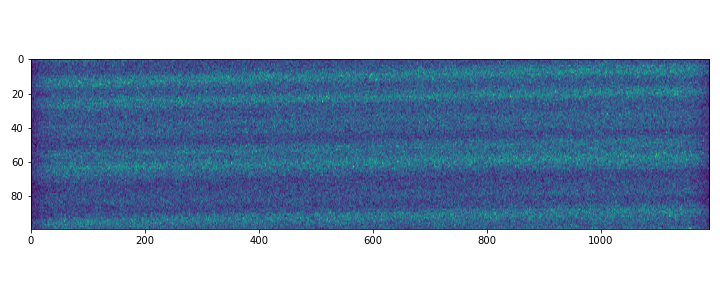

In [25]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(data.get('whitefield')[0])
ax.imshow(data.get('data')[:, 0], vmax=20)
ax.set_aspect(3)
plt.tight_layout()
plt.show()

In [25]:
st_obj = data.get_st()

st_obj = st_obj.update_reference(hval=80.0)
st_res = st_obj.iter_update_gd(sw_x=20, h0=80., blur=32.0, verbose=True, n_iter=40)

Calculating a step size...
step = 1


   0%            Iteration 0 / 40 [00:00<?, ?it/s]

Initial MSE = 0.384014, Initial h0 = 80.00


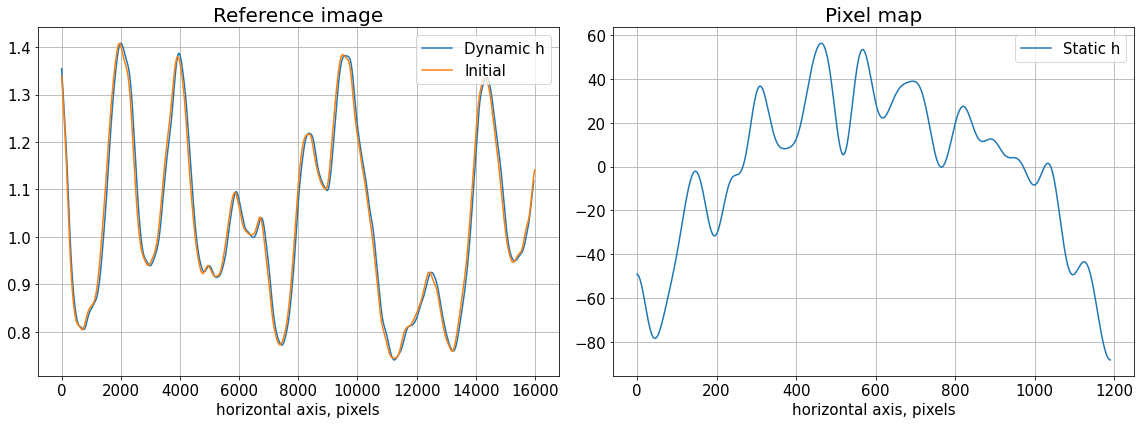

In [26]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Dynamic h')
axes[0].plot(st_obj.reference_image[0], label='Initial')
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('horizontal axis, pixels', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [27]:
data.update_phase(st_res)
fit_obj = data.get_fit()
fit_obj.defocus = np.abs(fit_obj.defocus)
fit = fit_obj.fit()
ph_fit = fit_obj.fit_phase()

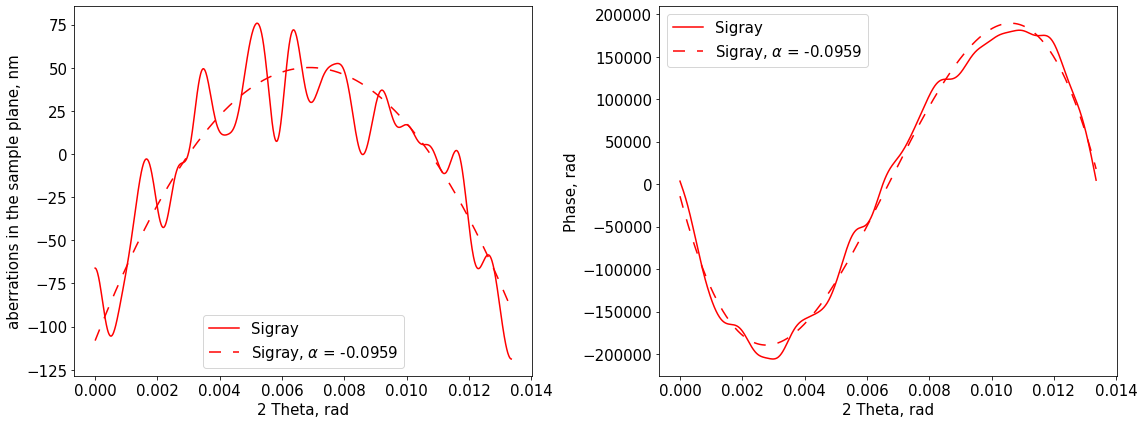

In [28]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.det_ap,
             fit_obj.pixel_aberrations * fit_obj.det_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.det_ap,
             fit_obj.model(fit['fit']) * fit_obj.det_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['c_3']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.det_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.det_ap, fit_obj.model(ph_fit['ph_fit']), 
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['c_3']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Experimental results

In [ ]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

In [10]:
np.asarray(np.ones(5, dtype=np.float64), dtype=np.uint32).dtype

dtype('uint32')

In [ ]:
data_dict = {}
res = {}

In [ ]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000),
            2797: (0, 1, 310, 1240), 2804: (0, 1, 180, 1220), 2894: (0, 1, 260, 1230), 2924: (0, 1, 250, 1200),
            2934: (0, 1, 320, 1240), 2936: (0, 1, 40, 1250), 2989: (0, 1, 200, 1245), 3029: (0, 1, 550, 1210),
            3254: (0, 1, 550, 1210)}

scan_num = 3649

data_dict[scan_num] = rst.cxi_converter_sigray(scan_num, dir_path='/gpfs/cfel/group/cxi/labs/MLL-Sigray',
                                               target='Mo', distance=None, lens='up')
data_dict[scan_num] = data_dict[scan_num].crop_data([200, 300, 390, 1380])
data_dict[scan_num] = data_dict[scan_num].update_mask('perc-bad', pmax=99.999)
data_dict[scan_num] = data_dict[scan_num].integrate_data(axis=0).mask_frames()

# data_dict[scan_num]_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_{scan_num:d}/Scan_{scan_num:d}.cxi'
# loader = rst.CXILoader()
# data_dict[scan_num] = loader.load(data_dict[scan_num]_path.format(scan_num), roi=roi_dict[scan_num])

In [ ]:
angles_series = {3649: 0.5, 3653: 1.0, 3655: 1.5}

for _scan_num in angles_series:
    data_dict[_scan_num] = rst.cxi_converter_sigray(_scan_num, target='Mo', distance=None, lens='up')
    data_dict[_scan_num] = data_dict[_scan_num].crop_data([200, 300, 390, 1380])
    data_dict[_scan_num] = data_dict[_scan_num].update_mask('perc-bad', pmax=99.999)
    data_dict[_scan_num] = data_dict[_scan_num].integrate_data(axis=0).mask_frames()
    data_dict[_scan_num] = data_dict[_scan_num].update_defocus(defocus_x=105e-6)

    st_obj = data_dict[_scan_num].get_st()
    st_rgd = st_obj.iter_update_gd(ls_ri=32., ls_pm=1., blur=14., sw_x=9, n_iter=100, verbose=True,
                                   learning_rate=1e0)
    data_dict[_scan_num] = data_dict[_scan_num].update_phase(st_rgd)
    
    res[_scan_num] = dev.st_update(I_n=data_dict[_scan_num].get('data').astype(np.float32),
                                   dij=data_dict[_scan_num].get('translations'),
                                   basis=data_dict[_scan_num].get('basis_vectors'),
                                   x_ps=data_dict[_scan_num].x_pixel_size,
                                   y_ps=data_dict[_scan_num].y_pixel_size,
                                   z=data_dict[_scan_num].distance,
                                   df=data_dict[_scan_num].defocus_x,
                                   search_window=(1, 100), n_iter=5, filter=10.)

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for _scan_num in angles_series:
    if data_dict[_scan_num]._isdefocus:
        ref_dx = data_dict[_scan_num].x_pixel_size *  data_dict[_scan_num].defocus_x / \
                 data_dict[_scan_num].distance * 1e6
#         axes[0].plot(ref_dx * np.arange(res[_scan_num]['I0'].shape[1]),
#                      res[_scan_num]['I0'][0], label=f'Scan {_scan_num:d}, PXST')
#         axes[0].plot(ref_dx * np.arange(data_dict[_scan_num].reference_image.shape[1]),
#                      data_dict[_scan_num].reference_image[0], label=f'Scan {_scan_num:d}, RST')
        axes[0].plot(data_dict[_scan_num].get('pixel_aberrations')[1, 0],
                     label=f'{angles_series[_scan_num]:.1f} deg misalignment, RST')
        axes[1].plot((res[_scan_num]['u'][1, 0] - np.arange(res[_scan_num]['u'].shape[-1])),
                     label=f'{angles_series[_scan_num]:.1f} deg misalignment, PXST')
        axes[0].set_title('Pixel mapping, pixels', fontsize=20)
        axes[1].set_title('Pixel mapping, pixels', fontsize=20)
for ax in axes:
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for _scan_num in angles_series:
    if data_dict[_scan_num]._isdefocus:
        ref_dx = data_dict[_scan_num].x_pixel_size *  data_dict[_scan_num].defocus_x / \
                 data_dict[_scan_num].distance * 1e6
        ax.plot(ref_dx * np.arange(data_dict[_scan_num].reference_image.shape[1]),
                  data_dict[_scan_num].reference_image[0], label=f'Scan {_scan_num:d}, RST')

ax.set_title('Reference profile, pixels', fontsize=20)
ax.set_xlabel('Fast axis, pixels', fontsize=15)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib notebook
fig, axes = plt.subplots(figsize=(9, 5))
axes.plot(data_dict[scan_num].get('whitefield')[0])
axes.set_title(f'Scan {scan_num:d}', fontsize=20)
axes.grid(True)
plt.show()

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(3, 1, figsize=(9, 9))
for idx, _scan_num in enumerate(angles_series):
    axes[idx].imshow(data_dict[_scan_num].get('data')[:, 0] *
                     data_dict[_scan_num].get('mask')[:, 0], vmax=10)
    axes[idx].set_aspect(2)
plt.tight_layout()
# plt.show()
plt.savefig('figures/angles_series.jpg', dpi=300)

In [ ]:
defoci = np.linspace(40e-6, 150e-6, 100)
ds_scan, extra = data_dict[scan_num].defocus_sweep(defoci, size=51, ls_ri=50, return_extra=True)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(defoci * 1e6, ds_scan)
ax.set_title('Defocus sweep', fontsize=20)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.tick_params(labelsize=15)
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# data = data.update_defocus(defocus_x=defocus_x)
data_dict[scan_num] = data_dict[scan_num].update_defocus(defocus_x=105e-6)

st_obj = data_dict[scan_num].get_st()

# st_rgd = st_obj.update_reference(ls_ri=10.)

st_rgd = st_obj.iter_update_gd(ls_ri=12., ls_pm=1., blur=22., sw_x=3, n_iter=100, verbose=True,
                               learning_rate=1e0)

data_dict[scan_num] = data_dict[scan_num].update_phase(st_rgd)

In [ ]:
res[scan_num] = dev.st_update(I_n=data_dict[scan_num].get('data').astype(np.float32),
                              dij=data_dict[scan_num].get('translations'),
                              basis=data_dict[scan_num].get('basis_vectors'),
                              x_ps=data_dict[scan_num].x_pixel_size,
                              y_ps=data_dict[scan_num].y_pixel_size, z=data_dict[scan_num].distance,
                              df=data_dict[scan_num].defocus_x,
                              search_window=(1, 100), n_iter=5, filter=15.)

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for _scan_num in angles_series:
    if data_dict[_scan_num]._isdefocus:
        ref_dx = data_dict[_scan_num].x_pixel_size *  data_dict[_scan_num].defocus_x / \
                 data_dict[_scan_num].distance * 1e6
#         axes[0].plot(ref_dx * np.arange(res[_scan_num]['I0'].shape[1]),
#                      res[_scan_num]['I0'][0], label=f'Scan {_scan_num:d}, PXST')
#         axes[0].plot(ref_dx * np.arange(data_dict[_scan_num].reference_image.shape[1]),
#                      data_dict[_scan_num].reference_image[0], label=f'Scan {_scan_num:d}, RST')
        axes[0].plot(data_dict[_scan_num].get('pixel_aberrations')[1, 0],
                     label=f'Scan {_scan_num:d}, RST')
        axes[1].plot((res[_scan_num]['u'][1, 0] - np.arange(res[_scan_num]['u'].shape[-1])),
                     label=f'Scan {_scan_num:d}, PXST')
        axes[0].set_title('Pixel mapping, pixels', fontsize=20)
        axes[1].set_title('Pixel mapping, pixels', fontsize=20)
for ax in axes:
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for _scan_num in data_dict:
    if data_dict[_scan_num]._isdefocus:
        fit_obj = data_dict[_scan_num].get_fit(center=87).remove_linear_term()
        fit = fit_obj.fit(max_order=3, loss='cauchy')
        axes[0].plot(fit_obj.get('thetas'), fit_obj.get('theta_aberrations') * 1e9,
                     label=f'Scan {_scan_num:d}, RST')
#         axes[0].plot(fit_obj.get('thetas'),
#                      (res[_scan_num]['u'][1, 0] - np.arange(res[_scan_num]['u'].shape[-1]) - 28) *
#                      fit_obj.pixel_size * data_dict[scan_num].defocus_x / fit_obj.distance**2 * 1e9,
#                      label=f'Scan {_scan_num:d}, PXST')
        axes[0].set_title('Angular displacements, nrad', fontsize=20)

        axes[1].plot(fit_obj.get('thetas'), fit_obj.get('phase'),
                     label=f'Scan {_scan_num:d}, RST')
        axes[1].plot(fit_obj.get('thetas'), fit_obj.model(fit['ph_fit']),
                     label=fr"RST $c_4$ = {fit['c_4']:.4f} rad/mrad^4")
    axes[1].set_title('Phase, rad', fontsize=20)
for ax in axes:
    ax.set_xlabel('Scattering angle, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
np.savetxt('test.txt', np.stack([fit_obj.get('thetas'), fit_obj.get('phase')], axis=1), fmt='%14.4f',
           header='[theta, rad]   [phase, rad]')

In [ ]:
center = 20
fit_rst = data.get_fit(center=center).remove_linear_term()
fit_rst = fit_rst.crop_data([10, fit_rst.pixels.size - 30])
fcf_rst = fit_rst.fit(max_order=3, loss='linear')

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(fit_rst.thetas, fit_rst.theta_aberrations * 1e9, 'b')
axes[0].plot(fit_rst.thetas, fit_rst.model(fcf_rst['fit']) * fit_rst.ref_ap * 1e9, 'b--',
             label=fr"RST $c_4 = {fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[0].set_title('Angular displacements, nrad', fontsize=20)

axes[1].plot(fit_rst.thetas, fit_rst.phase, 'b')
axes[1].plot(fit_rst.thetas, fit_rst.model(fcf_rst['ph_fit']), 'b--',
             label=fr"RST $c_4={fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[1].set_title('Phase, rad', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Scattering angles, rad', fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
data_path = '/gpfs/cfel/cxi/data/2019/NSLS-2019_Bajt-Sep/cxifiles/scan_81763/scan_81763.cxi'
loader = rst.CXILoader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', pmax=99.995)

In [ ]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
gb_images = []
ls_low = 1.
ls_high = 10.
for defocus in tqdm(df_nsls, total=len(df_nsls), desc='Generating defocus sweep'):
    st_obj = data_nsls.update_defocus(defocus).get_st().update_reference(ls_ri=1.5)
    grad_ss_high = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_low, 1),
                                axis=0, mode='reflect', num_threads=st_obj.num_threads)
    grad_ss_low = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_high, 1),
                               axis=0, mode='reflect', num_threads=st_obj.num_threads)
    grad_fs_high = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_low, 1),
                                axis=1, mode='reflect', num_threads=st_obj.num_threads)
    grad_fs_low = fft_convolve(st_obj.reference_image, gaussian_kernel(ls_high, 1),
                               axis=1, mode='reflect', num_threads=st_obj.num_threads)
    mean_med = gaussian_filter(st_obj.reference_image, (ls_low + ls_high) / 2, mode='reflect',
                               num_threads=st_obj.num_threads)
    gb_image = ((grad_ss_high - grad_ss_low)**2 + (grad_fs_high - grad_fs_low)**2) / mean_med**2
    gb_images.append(gb_image)

In [ ]:
%matplotlib inline
idx = 15
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(extra['reference_image'][idx], vmax=1.5)
axes[0].set_title('Reference image', fontsize=20)
axes[1].imshow(extra['r_image'][idx], vmax=2e-3)
axes[1].set_title('Local variance', fontsize=20)
axes[2].imshow(gb_images[idx], vmax=1e-3)
axes[2].set_title('Band-pass gradient', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.show()

In [ ]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls, extra = data_nsls.defocus_sweep(df_nsls, size=5., ls_ri=1.1, return_extra=True)

In [ ]:
gb_vals = np.array([np.mean(gb_image) for gb_image in gb_images])

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_nsls * 1e3, dss_nsls / np.mean(dss_nsls), label='Local variance')
ax.plot(df_nsls * 1e3, gb_vals / np.mean(gb_vals), label='Band-pass gradient')
ax.set_title('Defocus sweep', fontsize=20)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
data_nsls = data_nsls.update_defocus(defocus_x=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_y=0, sw_x=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, blur=6., sw_x=3, sw_y=3,
                                         n_iter=20, verbose=True, learning_rate=0.1)

In [ ]:
data_nsls = data_nsls.update_phase(st_rgd_nsls)
fit_obj_nsls = data_nsls.get_fit(axis=0)

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

In [ ]:
fit_obj = data.get_fit(center=150)
fit_obj = fit_obj.remove_linear_term()
fit_obj_nsls = fit_obj_nsls.crop_data([10, 240]).remove_linear_term()
fit_nsls = fit_obj_nsls.fit()
fit = fit_obj.crop_data([10, 650]).fit()

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.thetas, fit_obj.pixel_aberrations * fit_obj.defocus / fit_obj.distance,
             label='Sigray', c='r')
axes[0].plot(fit_obj.thetas, fit_obj.model(fit['fit']) * fit_obj.defocus / fit_obj.distance,
             label=fr"Sigray, $\alpha$ = {fit['c_3']:.4f}",
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj.thetas, fit_obj.phase, label='Sigray', c='r')

axes[0].plot(fit_obj_nsls.thetas,
             fit_obj_nsls.pixel_aberrations * fit_obj_nsls.defocus / fit_obj_nsls.distance,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.thetas,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.defocus / fit_obj_nsls.distance,
             label=fr"NSLS, $\alpha$ = {fit_nsls['c_3']:.4f}",
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.thetas, fit_obj_nsls.phase, label='NSLS', c='b')

axes[0].set_ylabel('Normalized phase gradient, \si{\micro\metre^-1}', fontsize=15)
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()